In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_excel("Projekt-2_Data.xlsx")
plt.rcParams['axes.grid'] = True

## ÚLOHA 1 – Bayesovské odhady

### a) Konjugované apriorní a aposteriorní rozdělení, prediktivní rozdělení 

> Předpokládáme, že počet připojení na internetovou síť za 1 ms je popsaný náhodnou veličinou
s Poissonovým rozdělením s parametrem 𝜆, t.j. 𝑋~𝑃𝑜(𝜆).
O parametru 𝜆 máme následující expertní odhad: každých 5 ms by mělo nastat 10 připojení.
Pozorovali jsme připojení po dobu 100 ms. Pozorovaní o počtu připojení za každou 1 ms jsou
uvedené v souboru measurements.csv ve sĺoupci „úloha_1 a)“.
Vašim zadáním je z této expertní informace urči konjugované apriorní rozdělení k parametru
Poissonova rozdělení a na základě pozorovaní určit aposteriorní rozdělení. Dále určete
apriorní a aposteriorní prediktivní rozdělení pozorovaní.

#### 1) Do jednoho obrázku vykreslíte apriorní a aposteriorní hustotou parametru Poissonova rozdělení 𝜆.  

Keďže máme informáciu o distribúcii intervalov medzi udalosťami (10 pripojení/5ms), môžme podľa tabuľky konjugovaných rozdelení, použiť Gamma rozdelenie na aproximácou Poissonovho rozdelenia. Pretože Gamma rozdelenie s $\alpha = k$, kde $k$ je počet udalosti a $\beta = \frac{1}{\lambda}$ konverguje k Poissonovmu rozdeleniu so strednou hodnotou $\lambda$.

In [3]:
from scipy.stats import gamma

$\alpha = 10$  
$\beta = \frac{1}{5}$

In [4]:
# Parametre apriornej gama distribúcie
lambda_poiss = 5
alpha = 10  # k
beta = 1 / lambda_poiss

# Generovanie hodnôt parametra lambda
lambda_values = np.linspace(0, 10, 1000)

# Výpočet apriornej hustoty gama distribúcie
prior_density = gamma.pdf(lambda_values, alpha, scale=beta)

In [5]:
postreior_a = alpha + df["uloha_1 a)"].sum()
posterior_l = lambda_poiss + df["uloha_1 a)"].count()
posterior_b = 1 / posterior_l
post_density = gamma.pdf(lambda_values, postreior_a, scale=posterior_b)

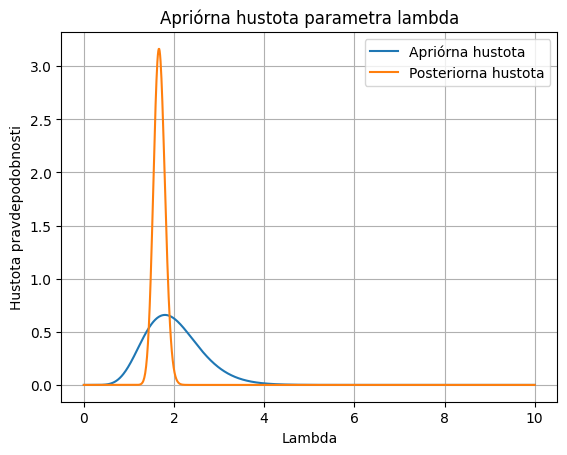

In [6]:
plt.plot(lambda_values, prior_density, label='Apriórna hustota')
plt.plot(lambda_values, post_density, label='Posteriorna hustota')
plt.title('Apriórna hustota parametra lambda')
plt.xlabel('Lambda')
plt.ylabel('Hustota pravdepodobnosti')
plt.legend()
plt.show()

#### 2) Do jednoho obrázku vykreslíte apriorní a aposteriorní prediktivní hustotou pozorovaní 𝑥 za jeden časový interval.  

In [7]:
from scipy.stats import poisson, nbinom
x_values = np.arange(df["uloha_1 a)"].min(), df["uloha_1 a)"].max() * 2 + 1)

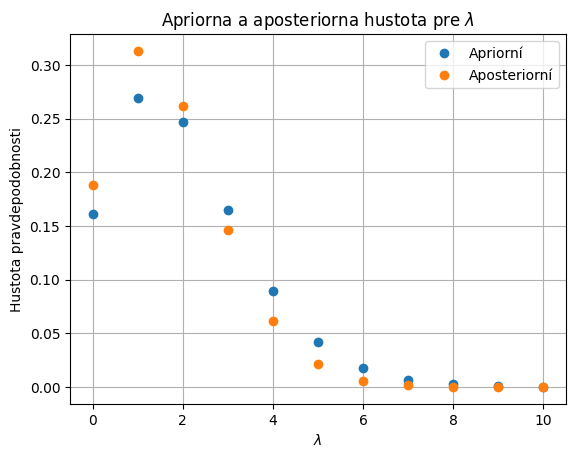

In [8]:
prior_distribution = gamma(alpha, scale=beta)
posterior_distribution = gamma(postreior_a, scale=posterior_b)

prior_predictive = poisson.pmf(x_values, mu=alpha/lambda_poiss)
posterior_predictive = poisson.pmf(x_values, mu=postreior_a/posterior_l)

prior_predictive = nbinom.pmf(x_values, n=alpha, p=lambda_poiss/(lambda_poiss+1))
posterior_predictive = nbinom.pmf(x_values, n=postreior_a, p=posterior_l/(posterior_l+1))

plt.plot(x_values, prior_predictive, 'o', label='Apriorní')
plt.plot(x_values, posterior_predictive, 'o', label='Aposteriorní')

plt.title('Apriorna a aposteriorna hustota pre $\lambda$')
plt.ylabel('Hustota pravdepodobnosti')
plt.xlabel('$\lambda$')
plt.legend()
plt.show()

#### 3) Sestrojte 95% interval spolehlivosti pro parametr 𝜆 z apriorního a aposteriorního rozdělení a porovnejte je.

In [9]:
print("95% Interval spolahlivosti pre 𝜆 z apriorneho rozdelenia:", prior_distribution.interval(0.95))
print("95% Interval spolahlivosti pre 𝜆 z aposteriorneho rozdelenia:", posterior_distribution.interval(0.95))

95% Interval spolahlivosti pre 𝜆 z apriorneho rozdelenia: (0.9590777392264868, 3.416960690283833)
95% Interval spolahlivosti pre 𝜆 z aposteriorneho rozdelenia: (1.4376938284869922, 1.9327207471868797)


#### 4) Vyberte si dva aposteriorní bodové odhady parametru 𝜆, porovnejte je a okomentujte jejich výběr.

In [10]:
median_posterior = gamma.ppf(0.5, postreior_a, scale=posterior_b)
print("Stredna hodnota aposteriorneho rozdelenia:", postreior_a / posterior_l)
print("Median aposteriorneho rozdelenia:", median_posterior)


Stredna hodnota aposteriorneho rozdelenia: 1.6761904761904762
Median aposteriorneho rozdelenia: 1.6730169441241727


Stredná hodnota a median sú jedny z najjeednoduchších parametrov :)

Sú relatívne blízko, čo nám môže napovedať, že graf hustoty pravdepodobnosti bude takmer symetrický.

#### 5) Vyberte si jeden apriorní a jeden aposteriorní bodový odhad počtu pozorovaní a porovnejte je.


In [11]:
from scipy.stats import nbinom
mean_prior_n = nbinom.mean(alpha, lambda_poiss/(lambda_poiss+1))
mean_posterior_n = nbinom.mean(postreior_a, posterior_l/(posterior_l+1))

# Výpis výsledků
print("Střední hodnota apriorního odhadu:", mean_prior_n)
print("Střední hodnota aposteriorního odhadu:", mean_posterior_n)

Střední hodnota apriorního odhadu: 1.9999999999999996
Střední hodnota aposteriorního odhadu: 1.6761904761904758


Vybral som strednu hodnotu :)

### b) Aproximace diskrétním rozdělením

> Víme, že délka zpracování procesu v milisekundách ms má odseknuté normální rozdělení (truncated normal distribution)
viz.: https://en.wikipedia.org/wiki/Truncated_normal_distribution s parametry
$$\mu = 3, \sigma2 = 1, a = 1$$
>
> Naší úlohou je odhadnout parametr $b$, t.j. maximální dobu trvání procesu. Máme historické
záznamy o jeho délce trvání (sloupec `uloha 1 a)_prior}`) na počítačích podobné výkonové
řady. Provedli jsme sérii pozorovaní po `10`, číslo série pozorovaní v tabulce v sloupci
„skupina“. Z těchto záznamů vyjádříte apriorní informaci o parametru $b$.
> 
> Ve sloupci `uloha_1 b)_pozorovania` jsou naše pozorování délky trvání procesu Vyjádřete
funkci věrohodnosti (sloupec `uloha_1 b)_pozorovania`) (v tomto případe také jen její
diskrétní aproximace) a následně diskrétní aposteriorní hustotu.

#### 1) Do jednoho grafu vykreslíte apriorní, aposteriorní hustotou a funkci věrohodnosti. Funkci věrohodnosti normujte tak, aby jej součet byl 1 kvůli porovnatelnosti v obrázku.

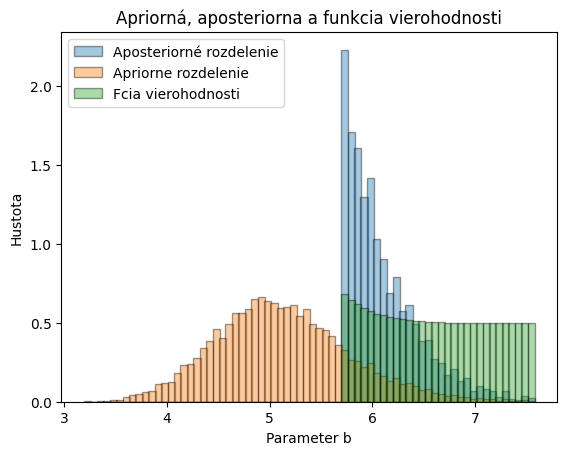

#### 2) Z aposteriorní hustoty určete 95% interval spolehlivosti (konfidenční interval) pro parametr $b$.

In [13]:
a = 0.05
sorted = df_aposteriori.sort_values("b")

cdf = df_aposteriori['p(b|h)'].cumsum()

lower_i = np.argmax(cdf >= a/2)
upper_i = np.argmax(cdf >= 1 - a/2)

print(f"95% interval spolahlivosti - ({sorted['b'][lower_i]}, {sorted['b'][upper_i]})")

95% interval spolahlivosti - (5.7315000000000005, 7.0465)


#### 3) Vyberte dva bodové odhady parametru 𝑏 a spočítejte je.  

Pre ich jednoduchosť vyberieme strednú hodnotu a median :)

In [14]:
print(f"Stredná hodnota: {(df_aposteriori['b'] * df_aposteriori['p(b|h)']).sum()}")
print(f"Medián: {df_aposteriori['b'][np.argmax(df_aposteriori['p(b|h)'].cumsum() >= 0.5)]}")

Stredná hodnota: 6.101053928918033
Medián: 5.9815000000000005


### ÚLOHA 2 – Regrese

In [15]:
import statsmodels.formula.api as smf
from patsy.builtins import *  # Q for fomula

#### 1) Pomocí zpětné eliminace určete vhodný regresní model. Za výchozí „plný“ model považujte plný kvadratický model (všechny interakce druhého řádu a všechny druhé mocniny, které dávají smysl).  

##### Zapište rovnici Vašeho finálního modelu.

Numerické atribúty je potrebné najskôr štandardizovať.

Pre spätnu elimináciu budem používať prah $0.05$, ak nejaký člen bude mať P-value vačšiu, odstránime ho.

In [16]:
standardized = pd.read_excel("Projekt-2_Data.xlsx", sheet_name="Úloha 2")
standardized["ActiveUsers"] = (standardized['ActiveUsers']-((standardized['ActiveUsers'].max()+standardized['ActiveUsers'].min())/2))/(standardized['ActiveUsers'].max()-standardized['ActiveUsers'].min())*2
standardized["ScrollingPct"] = (standardized['ScrollingPct']-((standardized['ScrollingPct'].max()+standardized['ScrollingPct'].min())/2))/(standardized['ScrollingPct'].max()-standardized['ScrollingPct'].min())*2

Nedáva zmysel dávať do vzorca $kategorické\ atributy^2$, ani ich násobiť medzi sebou, z prvotnej formule ich teda vynechám.

In [17]:
def highest_pvalues(model, n):
    p_values = model.pvalues.drop('Intercept')  # Drop the Intercept p-value
    return p_values.sort_values(ascending=False)[:n]

In [18]:
formula = 'Q("Ping [ms]") ~ C(OSType) + ActiveUsers + InteractingPct + ScrollingPct + ActiveUsers:InteractingPct + ActiveUsers:ScrollingPct + ActiveUsers:C(OSType) + InteractingPct:C(OSType) + InteractingPct:ScrollingPct + ScrollingPct:C(OSType) + I(ActiveUsers ** 2) + I(InteractingPct ** 2) + I(ScrollingPct ** 2)'

model = smf.ols(formula, data=standardized).fit()

print(highest_pvalues(model, 3))

ScrollingPct:C(OSType)[T.Windows]    0.646594
ScrollingPct:C(OSType)[T.iOS]        0.376034
ScrollingPct:C(OSType)[T.MacOS]      0.125717
dtype: float64


Najvyššie P-hodnoty má kombinácia $ScrollingPct * OSType$, odstránime ju

In [19]:
formula = 'Q("Ping [ms]") ~ C(OSType) + ActiveUsers + InteractingPct + ScrollingPct + ActiveUsers:InteractingPct + ActiveUsers:ScrollingPct + ActiveUsers:C(OSType) + InteractingPct:C(OSType) + InteractingPct:ScrollingPct + I(ActiveUsers ** 2) + I(InteractingPct ** 2) + I(ScrollingPct ** 2)'

model = smf.ols(formula, data=standardized).fit()

print(highest_pvalues(model, 3))

InteractingPct:C(OSType)[T.iOS]        0.920767
InteractingPct:C(OSType)[T.MacOS]      0.887964
InteractingPct:C(OSType)[T.Windows]    0.875622
dtype: float64


Keďže $InterractingPct$ a $ScrollingPct$ sú navzájom inverzné ($InteractingPct + ScrollingPct = 1$, môžme $InteractingPct$ odstrániť

In [20]:
formula = 'Q("Ping [ms]") ~ C(OSType) + ActiveUsers + ScrollingPct + ActiveUsers:ScrollingPct + ActiveUsers:C(OSType) + I(ActiveUsers ** 2) + I(ScrollingPct ** 2)'

model = smf.ols(formula, data=standardized).fit()

print(highest_pvalues(model, 3))

I(ScrollingPct ** 2)                0.277532
ActiveUsers:C(OSType)[T.Windows]    0.012524
ActiveUsers:C(OSType)[T.iOS]        0.000783
dtype: float64


Odstránime už len $ScrollingPct^2$

In [21]:
formula = 'Q("Ping [ms]") ~ C(OSType) + ActiveUsers + ScrollingPct + ActiveUsers:ScrollingPct + ActiveUsers:C(OSType) + I(ActiveUsers ** 2)'

model = smf.ols(formula, data=standardized).fit()

print(highest_pvalues(model, 3))

ActiveUsers:C(OSType)[T.Windows]    0.014941
ActiveUsers:C(OSType)[T.iOS]        0.001016
ActiveUsers:C(OSType)[T.MacOS]      0.000005
dtype: float64


In [22]:
intercept = model.params['Intercept']
coeffs = model.params.drop('Intercept')
coeff_names = coeffs.index

equation = f'Ping = {intercept:.4f} + ' + ' + '.join([f'{coeff:.4f}*{var}' for coeff, var in zip(coeffs, coeff_names)])

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Q("Ping [ms]")   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     264.4
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          1.69e-190
Time:                        22:10:44   Log-Likelihood:                -1599.1
No. Observations:                 502   AIC:                             3220.
Df Residuals:                     491   BIC:                             3267.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           49.4236      0.633     78.131      0.000      48.181      50.666
C(OSType)[T.MacOS]                   8.7999      0.777     11.318      0.000       7.272      10.328
C(OSType)[T.Windows]                 4.1936      0.781      5.367      0.000       2.658       5.729
C(OSType)[T.iOS]                    -5.3112      0.800     -6.640      0.000      -6.883      -3.740
ActiveUsers                         20.8512      1.154     18.074      0.000      18.584      23.118
ActiveUsers:C(OSType)[T.MacOS]       6.9549      1.501      4.633      0.000       4.005       9.904
ActiveUsers:C(OSType)[T.Windows]    -3.6108      1.478     -2.442      0.015      -6.515      -0.706
ActiveUsers:C(OSType)[T.iOS]        -5.0588      1.530     -3.306      0.001      -8.065      -2.052
ScrollingPct                        -9.1649      0.453    -20.253      0.000     -10.054      -8.276
ActiveUsers:ScrollingPct             7.5598      0.873      8.662      0.000       5.845       9.275
I(ActiveUsers ** 2)                 -9.9907      1.054     -9.480      0.000     -12.061      -7.920
==============================================================================
Omnibus:                      230.750   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3263.977
Skew:                           1.617   Prob(JB):                         0.00
Kurtosis:                      15.066   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
m = smf.ols(formula, data=standardized)
X = pd.DataFrame(m.exog, columns=m.exog_names)
vif = pd.Series([variance_inflation_factor(X.values, i) 
                 for i in range(X.shape[1])], 
                 index=X.columns)
vif_df = vif.to_frame()
# Nastavení názvu sloupce
vif_df.columns = ['VIF']
vif_df

,VIF
Intercept,5.740521
C(OSType)[T.MacOS],1.728634
C(OSType)[T.Windows],1.713664
C(OSType)[T.iOS],1.650624
ActiveUsers,5.156656
ActiveUsers:C(OSType)[T.MacOS],2.373246
ActiveUsers:C(OSType)[T.Windows],2.410102
ActiveUsers:C(OSType)[T.iOS],2.216928
ScrollingPct,1.031438
ActiveUsers:ScrollingPct,1.036824


`VIF` pre jednotlivé prediktory je taktiež menší ako 10. Ich korelačné koeficienty su taktiež nízke.  

Rovnica finálneho modelu je:

In [24]:
equation

'Ping = 49.4236 + 8.7999*C(OSType)[T.MacOS] + 4.1936*C(OSType)[T.Windows] + -5.3112*C(OSType)[T.iOS] + 20.8512*ActiveUsers + 6.9549*ActiveUsers:C(OSType)[T.MacOS] + -3.6108*ActiveUsers:C(OSType)[T.Windows] + -5.0588*ActiveUsers:C(OSType)[T.iOS] + -9.1649*ScrollingPct + 7.5598*ActiveUsers:ScrollingPct + -9.9907*I(ActiveUsers ** 2)'

##### Diskutujte splnění předpokladů lineární regrese a základní regresní diagnostiky.

Predpoklady lineárnej regresie sú:  

- Lineárny vzťah medzi nezávislými premennými a závislou  
- Minimálna multikolinearita  
- Homoskedasticita  
- Normálne rozdelenie rezidui  
- Nezávislosť rezidui  
- Rezidua bez odlahlých hodnôt  

Predpoklady môžme overiť na nasledujúcich grafoch:

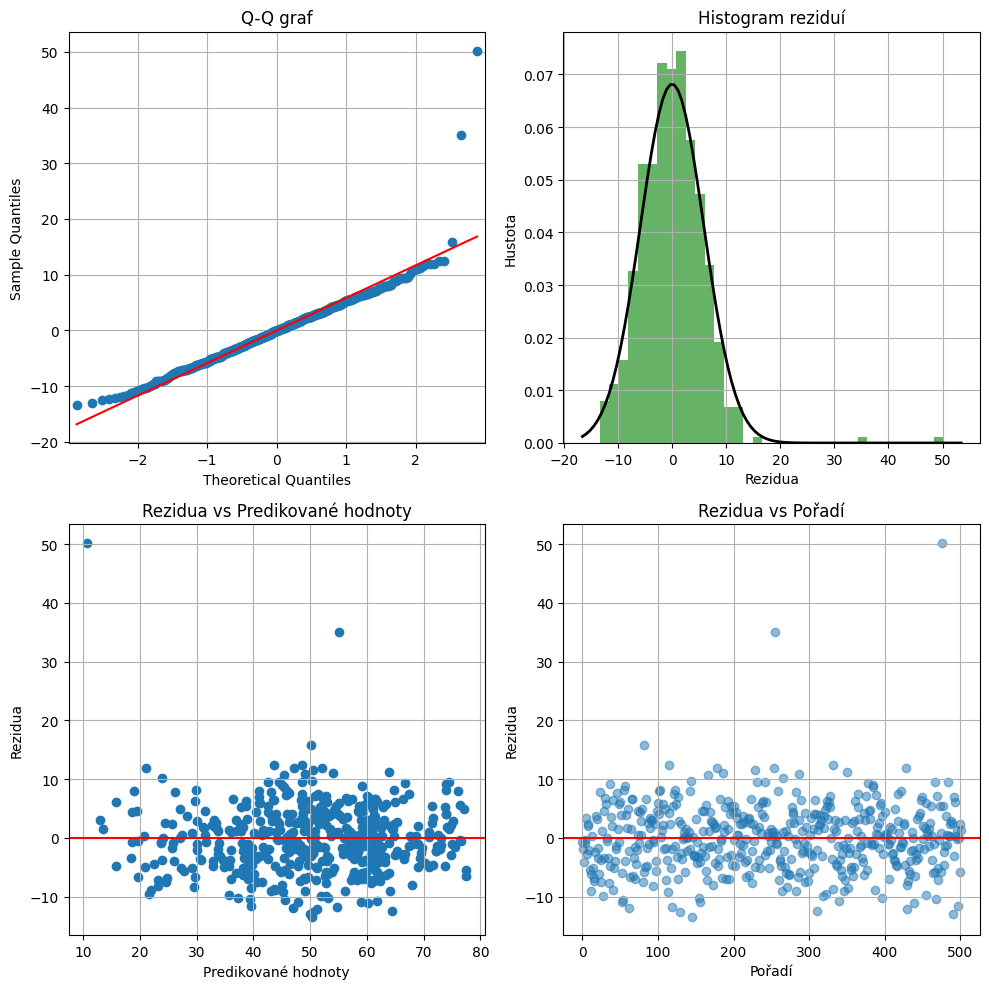

In [25]:
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

## QQ
fig, axs = plt.subplots(2, 2, figsize=(10,10))
qq = qqplot(model.resid, line='s', ax=axs[0, 0])
axs[0, 0].set_title('Q-Q graf')

## Histogram
axs[0, 1].hist(model.resid, bins='auto', density=True, alpha=0.6, color='g')
axs[0, 1].set_title('Histogram reziduí')
# Vykreslení odpovídající Gaussovy křivky
xmin, xmax = axs[0, 1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(model.resid), np.std(model.resid))
axs[0, 1].plot(x, p, 'k', linewidth=2)
axs[0, 1].set_xlabel("Rezidua")
axs[0, 1].set_ylabel("Hustota")

#res vs fit
axs[1, 0].scatter(model.fittedvalues, model.resid)
axs[1, 0].axhline(y=0, color='r', linestyle='-') 
axs[1, 0].set_xlabel('Predikované hodnoty')
axs[1, 0].set_ylabel('Rezidua')
axs[1, 0].set_title('Rezidua vs Predikované hodnoty')

# res vs order
axs[1, 1].scatter(range(len(model.resid)), model.resid, alpha=0.5)
axs[1, 1].axhline(y=0, color='r', linestyle='-') 
axs[1, 1].set_title("Rezidua vs Pořadí")
axs[1, 1].set_xlabel("Pořadí")
axs[1, 1].set_ylabel("Rezidua")
fig.tight_layout()
plt.show()


Z grafov vyššie môžme povedať, že až na odlahlé hodnoty, predpoklady sú splnené.

##### Pokud (až během regresního modelování) identifikujete některé „extrémně odlehlé hodnoty“ můžete ty „nejodlehlejší“ hodnoty, po alespoň krátkém zdůvodnění, vyřadit.  

Odlahlé hodnoty nám ovplyvňujú celý model - regresnú priamku a môžu teda negatívne ovplyvniť predikcie.

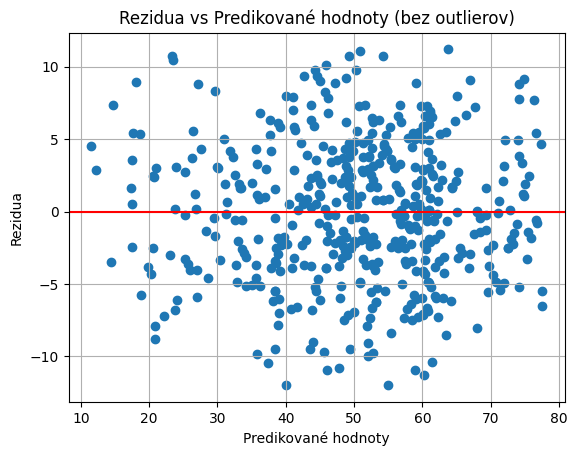

In [26]:
influence = model.get_influence()
# Leverage 
leverage = influence.hat_matrix_diag
# Cookovy D hodnoty (a p-hodnoty) jako n-tice polí [n x 2]
cooks_d = influence.cooks_distance
# Standardizovaná rezidua
standardized_residuals = influence.resid_studentized_internal
# Studentizovaná rezidua
studentized_residuals = influence.resid_studentized_external
#tabulka dohromady dořešit změny počtu řádků
outl_stats_df = pd.DataFrame({
    'Leverage': leverage,
    'Standardized Residuals': standardized_residuals,
    'Studentized Residuals': studentized_residuals,
    'Cook\'s Distance': cooks_d[0],
    'Cook\'s Distance_p-value': cooks_d[1]
}, index=standardized.index)
#vyber jen "zajímavý" hodnoty

merged_df = standardized.join(outl_stats_df)
outl_stats_df = merged_df[~((outl_stats_df['Leverage'] > 3*len(model.params)/standardized.shape[0]) | (np.abs(outl_stats_df['Standardized Residuals']) > 2) | (outl_stats_df['Cook\'s Distance_p-value'] < 0.05))]

model_outl = smf.ols(formula, data=outl_stats_df).fit()
plt.scatter(model_outl.fittedvalues, model_outl.resid)
plt.axhline(y=0, color='r', linestyle='-') 
plt.xlabel('Predikované hodnoty')
plt.ylabel('Rezidua')
plt.title('Rezidua vs Predikované hodnoty (bez outlierov)')
plt.show()

#### 2) Pomocí Vašeho výsledného modelu identifikujte, pro které nastavení parametrů má odezva nejproblematičtější hodnotu.  



V doméne nášho problému - odhadu pingu sú problémove hodnoty pingu tie záporne (je nezmysel mať záporný ping) a veľmi vysoké hodnoty.
Z formule modelu vieme, že predikciu pingu nám budu smerom nahor "ovplyvnovat" najmä parametre `OSType.MacOS`, `OSType.Windows`, `ActiveUsers * OSType.MacOS` a `ActiveUsers * ScrollingPct`.

In [27]:
predicted = model.predict()
print(f"Najmenšia hodnota: {predicted[model.predict().argmin()]}")
print(f"Najvyššia hodnota: {predicted[model.predict().argmax()]}")

Najmenšia hodnota: 10.759873693218516
Najvyššia hodnota: 77.48576486184544


#### 3) Odhadněte hodnotu odezvy uživatele s Windows, při průměrném nastavení ostatních parametrů a vypočtěte konfidenční interval a predikční interval pro toto nastavení.

Pre konfidenčné intervaly si zvolíme $\alpha = 0.05$

Vyfiltrujeme si záznamy s `OSType` `Windows` a nastavíme im `ActiveUsers`, `InteractingPct`, `ScrollingPct` na priemerné hodnoty týchto atribútov po vyfiltrovaní iných `OSType`:

In [28]:
means = standardized.copy()
means = means[means["OSType"] == "Windows"]
means["ActiveUsers"] = means["ActiveUsers"].mean()
means["InteractingPct"] = means["InteractingPct"].mean()
means["ScrollingPct"] = means["ScrollingPct"].mean()

In [29]:
prediction = model.get_prediction(means)
pred = prediction.summary_frame(alpha=0.05).values[0]

print("Odhad hodnoty pingu Windows užívatelov:", pred[0])
print(f"Predikčný interval: ({pred[2]}, {pred[3]})")
print(f"Konfidenčný interval: ({pred[4]}, {pred[5]})")

Odhad hodnoty pingu Windows užívatelov: 54.77686011282962
Predikčný interval: (53.61534652772431, 55.93837369793492)
Konfidenčný interval: (43.096328560694246, 66.45739166496499)


#### 4) Na základě jakýchkoli vypočtených charakteristik argumentujte, zdali je Váš model „vhodný“ pro další použití.  

Hodnota `R-squared` je relatívne vysoká, môžme teda povedať, že model relativne dobre opisuje variabilitu nezávislej premennej `ping`. Taktiež, aj charakteristika modelu `Adjusted R-squared` je vysoká, čo vypovedá o tom, že model používa "správne" nezávisle atributy.
Štatisticky významné atributy sme vyberali podla p-value, ich významnosť sme potom overili aj výpočtom hodnôt `VIF`.

Model je teda vhodný na ďalšie použitie, akurát by bolo vhodné, model najskôr validovať na dátach, ktoré sa nepoužili na jeho trenovanie.